In [19]:
import logging
import os
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import uxarray
import xarray
from metpy.units import units
from sklearn.neighbors import BallTree as SKBallTree
from tqdm import tqdm

import G211  # 80-km CONUS grid
from util import dBZfunc, dec_ax, mkcoord, trim_ll

degE = units.parse_expression("degree_E")
degN = units.parse_expression("degree_N")

try:  # Avoid ValueError when assigning cmap again
    cmap = cmaps.WhiteBlueGreenYellowRed
except ValueError:
    pass
%matplotlib inline

## Craig's FV3 HWT

In [2]:
idate = pd.to_datetime("20230522")
# Base data path
base_path = Path(
    "/glade/campaign/mmm/parc/schwartz/HWT2023/fv3_det/gfdl_2023cSHiELDconfig"
) / idate.strftime("%Y%m%d%H")

# Path to Grid file
grid_path = base_path / "grid_spec.nest02.tile7.nc"
print(grid_path)

name_dict = {"grid_lont": "lonCell", "grid_latt": "latCell"}

# Open the Grid file
grid_ds = xarray.open_dataset(grid_path).stack(nCells=("grid_yt", "grid_xt")).rename(name_dict)
# before computing the triangulation
grid_ds["lonCell"] = ((grid_ds["lonCell"] + 180) % 360) - 180

data_path = base_path / "atmos_sos.nest02.tile7.nc"
# Open data files
ds = (
    xarray.open_mfdataset(data_path)
    .stack(nCells=("grid_yt", "grid_xt"))  # make 1-dimensional for triangulate function
    .rename({"REFC": "refl10cm_max", "time": "Time"})
)

/glade/campaign/mmm/parc/schwartz/HWT2023/fv3_det/gfdl_2023cSHiELDconfig/2023052200/grid_spec.nest02.tile7.nc


## Robert Nystrom's MPAS

In [3]:
idate = pd.to_datetime("20180429T00")
base_path = Path(
    # "/glade/scratch/nystrom/pandac/nystrom_3denvar_6h_OIE120km_VarBC_v2.0/CyclingFC"
    "/glade/derecho/scratch/nystrom/pandac/nystrom_ForecastFromGFSAnalysesMPT_TEST/ExtendedFC/2022060600/mean"
    # "/glade/scratch/nystrom/pandac/nystrom_4denvar_6h_7slots_O30kmIE60km_VarBC_2out_v2.0/CyclingFC"
)
# base_path /= idate.strftime("%Y%m%d%H")
# grid_path = (list(base_path.glob("static.*.nc"))[0],)
grid_path = base_path.glob("static.655*.nc")
grid_path

<generator object Path.glob at 0x15471f0a7de0>

## Craig's MPAS HWT

In [4]:
idate = pd.to_datetime("20230429T00")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_5"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
var_names = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=3),
        end=idate + pd.Timedelta(hours=9),
        freq="3H",
    )
]
data_paths = [base_path / name for name in var_names]

uxds = uxarray.open_mfdataset(
    grid_path, data_paths, concat_dim="Time", combine="nested", use_dual=False
)
print(uxds.source_datasets)

[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_03.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_06.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023042900/post/mem_5/diag.2023-04-29_09.00.00.nc')]


/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/uxarray/grid/geometry.py:107: UserWarning: Converting to a GeoDataFrame with over 1,000,000 faces may take some time.
  warnings.warn(


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
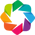

CPU times: user 23.7 s, sys: 2.57 s, total: 26.3 s
Wall time: 57.4 s


:DynamicMap   []
   :Image   [x,y]   (x_y refl10cm_max)

In [5]:
%%time
uxds["refl10cm_max"].isel(Time=2).plot.rasterize(
    method="polygon",
    width=800,
    height=400,
    dynamic=True,
    cmap=cmap,
    exclude_antimeridian=True,
)

## Trim global mesh to lat/lon box

In [5]:
# limit to lat lon box

lat0, lat1 = 41, 42.5
lon0, lon1 = -75, -70

# lat0, lat1 = 35, 43
# lon0, lon1 = -83, -66

lon_bounds = (lon0, lon1)
lat_bounds = (lat0, lat1)
grid_ds, ds = trim_ll(grid_path, data_paths, lon_bounds, lat_bounds)


figw = 12

triang = tri.Triangulation(grid_ds.lonCell, grid_ds.latCell)

projection = ccrs.LambertConformal(central_longitude=-82)
if lon1 - lon0 > 15:
    projection = ccrs.PlateCarree()


var = ds["refl10cm_max"].isel(Time=0).compute()

norm = mpl.colors.Normalize(vmin=0, vmax=50)

## Upscale to NCEP grid 211 (80 km) as in uxarray (SKBallTree)
<li>rectangular region of influence</li>
<li>circular region of influence</li>

ValueError: The length of c must match either the number of points or the number of triangles

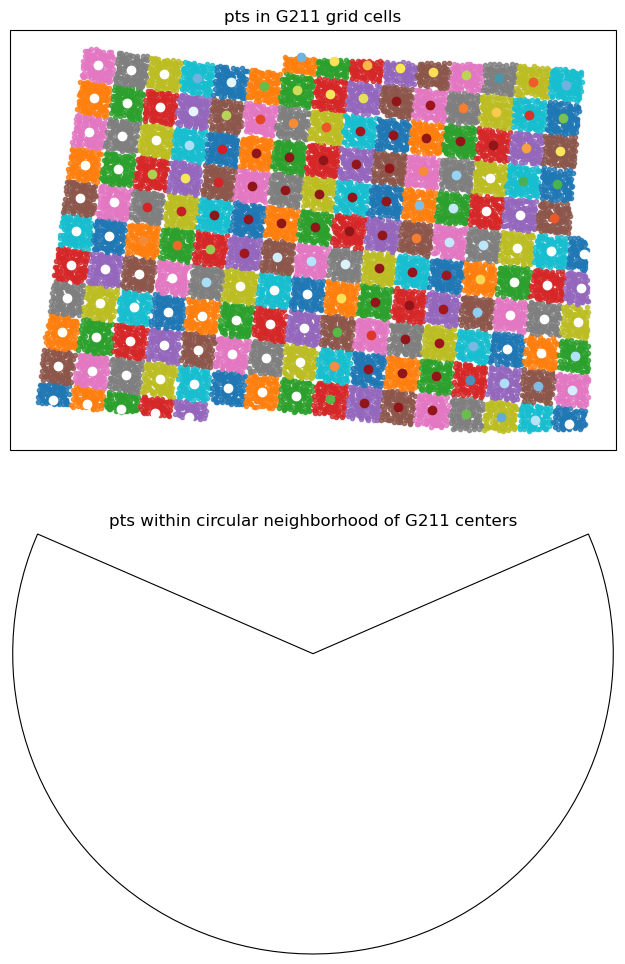

In [21]:
%%time
warnings.filterwarnings("ignore", message="Approximating coordinate system")
latlon = np.deg2rad(np.c_[grid_ds["latCell"], grid_ds["lonCell"]])
X = np.deg2rad(np.c_[G211.lat.ravel(), G211.lon.ravel()])

# List MPAS indices closest to each 80-km grid cell
idxs = SKBallTree(X, metric="haversine").query(latlon, return_distance=False)

fig, axes = plt.subplots(nrows=2, figsize=(figw, 12), subplot_kw=dict(projection=projection))

# optionally coarsen for speed
coarsen = dict(nCells=int(np.sqrt(ds.nCells.size) / 50), boundary="trim")
logging.warning(coarsen)

ax = axes[0]
ax.set_title("pts in G211 grid cells")
for ig, (glon, glat) in enumerate(zip(G211.lon.ravel(), G211.lat.ravel())):
    if glon < lon0 or glon >= lon1:
        continue
    if glat < lat0 or glat >= lat1:
        continue
    j = [i for i, (idx,) in enumerate(idxs) if idx == ig]
    if len(j) == 0:
        continue

    cc = ax.scatter(
        grid_ds["lonCell"].isel(nCells=j).coarsen(**coarsen).mean(),
        grid_ds["latCell"].isel(nCells=j).coarsen(**coarsen).mean(),
        transform=ccrs.PlateCarree(),
        marker=".",
        alpha=0.8,
    )
    c = dBZfunc(var[j], np.max)
    gs = ax.plot(
        glon,
        glat,
        color=cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c),
        transform=ccrs.PlateCarree(),
        marker="o",
        alpha=1,
    )


# List MPAS indices within rptdist of each 80-km grid cell center
ax = axes[1]
ax.set_title("pts within circular neighborhood of G211 centers")
tree = SKBallTree(latlon, metric="haversine")
rptdist = 40  # km
r = np.deg2rad(rptdist / 111.1)
idxs = tree.query_radius(X, r)

mm = ax.tripcolor(
    triang,
    var,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
)
fig.colorbar(mm, ax=axes, orientation="horizontal", shrink=0.6)

for i, idx in enumerate(tqdm(idxs)):
    if i % 1 > 0:
        continue
    if len(idx) == 0:
        continue

    c = dBZfunc(var[idx], np.max)
    cc = ax.scatter(
        grid_ds["lonCell"][idx].coarsen(**coarsen).mean(),
        grid_ds["latCell"][idx].coarsen(**coarsen).mean(),
        c=[cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c)],
        transform=ccrs.PlateCarree(),
        marker=".",
        alpha=0.1,
    )
    ax.scatter(
        G211.lon.ravel()[i],
        G211.lat.ravel()[i],
        c=c,
        transform=ccrs.PlateCarree(),
        marker="o",
        alpha=1,
        cmap=cmap,
        norm=norm,
    )
    ax.tissot(
        rad_km=rptdist,
        lons=G211.lon.ravel()[i],
        lats=G211.lat.ravel()[i],
        alpha=0.1,
        facecolor="white",
        edgecolor="black",
    )

[dec_ax(ax, (*lon_bounds, *lat_bounds)) for ax in axes]

plt.suptitle(f"{len(grid_ds.lonCell)} cells")

## Upscale to 30-km mesh

CPU times: user 1.66 s, sys: 44.4 ms, total: 1.71 s
Wall time: 2.01 s


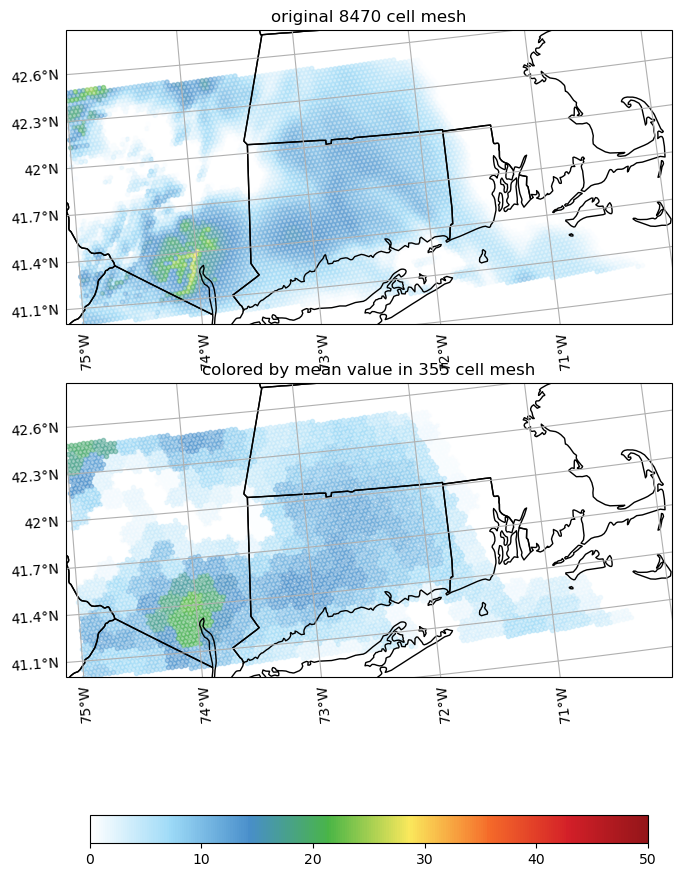

In [7]:
%%time
fig, axes = plt.subplots(
    nrows=2,
    figsize=(figw, 12),
    subplot_kw=dict(projection=projection),
)

ax = axes[0]
ax.set_title(f"original {len(grid_ds.lonCell)} cell mesh")
cc = ax.scatter(
    grid_ds["lonCell"],
    grid_ds["latCell"],
    c=var,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    marker=".",
    alpha=0.5,
)

fig.colorbar(mm, ax=axes, orientation="horizontal", shrink=0.6)

# Upscale to coarse mesh
coarse_mesh = xarray.open_dataset(
    "/glade/campaign/mmm/parc/schwartz/MPAS_regional/15km_mesh_regional/mpas_init/regional_15km_mesh_2000km.static.nc"
)
coarse_mesh["lonCell"] = np.degrees(coarse_mesh.lonCell)
coarse_mesh["latCell"] = np.degrees(coarse_mesh.latCell)
# before computing the triangulation
coarse_mesh["lonCell"] = ((coarse_mesh["lonCell"] + 180) % 360) - 180

ibox = (
    (coarse_mesh.lonCell >= lon0)
    & (coarse_mesh.lonCell < lon1)
    & (coarse_mesh.latCell >= lat0)
    & (coarse_mesh.latCell < lat1)
)
logging.info("Trim latCell and lonCell")
coarse_mesh = coarse_mesh[["latCell", "lonCell"]].where(ibox, drop=True)

X = np.c_[coarse_mesh.latCell.values.ravel(), coarse_mesh.lonCell.values.ravel()]
# List MPAS indices closest to each coarse mesh cell
idxs = SKBallTree(np.deg2rad(X), metric="haversine").query(latlon, return_distance=False)

coarse_var = np.empty(coarse_mesh["lonCell"].shape)
coarse_var.fill(np.nan)

axes[1].set_title(f"colored by mean value in {len(coarse_mesh.lonCell)} cell mesh")

for idx in np.unique(idxs):
    i = idxs.squeeze() == [idx]
    if any(i):
        coarse_var[idx] = dBZfunc(var.values[i], np.mean)
        c = dBZfunc(var.values[i], np.mean)
        cc = axes[1].scatter(
            grid_ds["lonCell"][i],
            grid_ds["latCell"][i],
            c=[cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(c)],
            transform=ccrs.PlateCarree(),
            marker=".",
            alpha=0.5,
        )


for ax in axes:
    dec_ax(ax, (*lon_bounds, *lat_bounds))

coarse_mesh[var.name] = coarse_var

## Plot TC centers with radius of influence and location of maximum
### optional filter by hemisphere or quandrant about center point

### HWT 2023 MPAS

In [8]:
idate = pd.to_datetime("20230531T00")
base_path = (
    Path("/glade/campaign/mmm/parc/schwartz/HWT2023/mpas")
    / idate.strftime("%Y%m%d%H")
    / "post/mem_4"
)
grid_path = "/glade/campaign/mmm/parc/schwartz/MPAS/15-3km_mesh/mpas_init/static.nc"
# Paths to Data Variable files
var_names = [
    d.strftime("diag.%Y-%m-%d_%H.%M.%S.nc")
    for d in pd.date_range(
        start=idate + pd.Timedelta(hours=36),
        end=idate + pd.Timedelta(hours=48),
        freq="6H",
    )
]
data_paths = [base_path / name for name in var_names]
# Tropical storm ARLENE
track = [
    (pd.to_datetime("20230601T12"), -87.5, 28.6),
    (pd.to_datetime("20230601T18"), -87.5, 28.6),
    (pd.to_datetime("20230602T00"), -87.6, 28.7),
]
lat0, lat1 = 24, 32
lon0, lon1 = -93, -80
grid_ds, ds = trim_ll(grid_path, data_paths, (lon0, lon1), (lat0, lat1))

In [9]:
uxds = uxarray.open_mfdataset(
    grid_path, data_paths, concat_dim="Time", combine="nested", use_dual=False
)
print(uxds.source_datasets)

[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_12.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-01_18.00.00.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2023/mpas/2023053100/post/mem_4/diag.2023-06-02_00.00.00.nc')]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
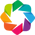

:DynamicMap   []
   :Image   [x,y]   (x_y refl10cm_max)

In [10]:
uxds["refl10cm_max"].subset.bounding_box(lon_bounds, lat_bounds).isel(Time=2).plot.rasterize(
    method="polygon",
    width=800,
    height=400,
    dynamic=True,
    cmap=cmap,
    exclude_antimeridian=True,
)

In [11]:
%%time
# List of TC centers
X = np.array([[lat, lon] for t, lon, lat in track])  # lat, lon
latlon = np.vstack((np.deg2rad(grid_ds.latCell.values), np.deg2rad(grid_ds.lonCell.values))).T
tree = SKBallTree(latlon, metric="haversine")

rptdist = 300  # km
r = np.deg2rad(rptdist / 111.0)
idxs = tree.query_radius(np.deg2rad(X), r)
idxs

CPU times: user 100 ms, sys: 1.02 ms, total: 101 ms
Wall time: 193 ms


array([array([103775,  29997, 103778, ..., 100687, 100688, 100685]),
       array([103775,  29997, 103778, ..., 100687, 100688, 100685]),
       array([103775,  29997, 103778, ..., 100683, 100684, 100685])],
      dtype=object)

CPU times: user 48.3 ms, sys: 19 ms, total: 67.2 ms
Wall time: 203 ms


/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.

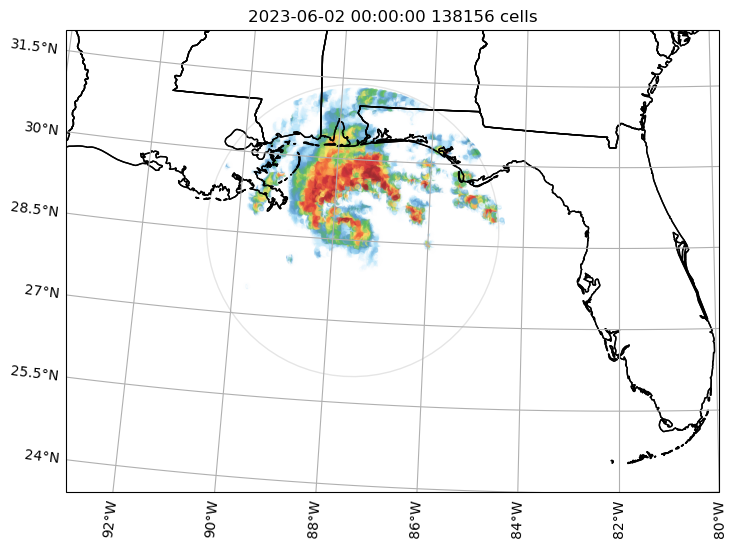

In [13]:
%%time
t = 2
fig, ax = plt.subplots(
    figsize=(figw, 6),
    subplot_kw=dict(projection=projection),
)
var = ds["refl10cm_max"].isel(Time=t, nCells=idxs[0]).compute()

ax.set_title(f"{track[t][0]} {len(grid_ds.lonCell)} cells")
cc = ax.scatter(
    grid_ds["lonCell"].isel(nCells=idxs[0]),
    grid_ds["latCell"].isel(nCells=idxs[0]),
    c=var,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    marker=".",
    alpha=0.5,
)
ax.tissot(
    rad_km=rptdist,
    lons=[track[t][1]],
    lats=[track[t][2]],
    alpha=0.1,
    facecolor="white",
    edgecolor="black",
)

dec_ax(ax, (lon0, lon1, lat0, lat1))
ax.add_feature(cfeature.STATES)

fig.colorbar(mm, ax=axes, orientation="horizontal", shrink=0.6)

In [14]:
grid_ds.latCell[6080], uxds.uxgrid.face_lon[5081942], uxds.uxgrid.face_lat[5081942]

(<xarray.DataArray 'latCell' ()> Size: 4B
 array(24.679302, dtype=float32),
 <xarray.DataArray 'face_lon' ()> Size: 4B
 array(-73.0025, dtype=float32),
 <xarray.DataArray 'face_lat' ()> Size: 4B
 array(41.4061, dtype=float32)
 Attributes:
     standard_name:  latitude
     long name:      Latitude of the center of each face
     units:          degrees_north)

In [15]:
uxtree = uxds.uxgrid.get_ball_tree()
xy = np.flip(X, axis=1)

Text(0.5, 1.0, ' (138156 cells)')

/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:799: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.

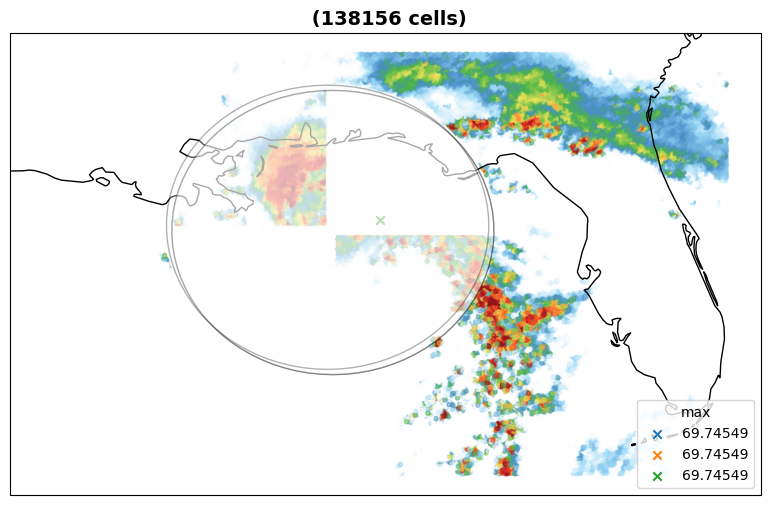

In [20]:
fig, ax = plt.subplots(figsize=(figw, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))
var = ds["refl10cm_max"].isel(Time=0)
cc = ax.scatter(
    grid_ds["lonCell"],
    grid_ds["latCell"],
    c=var,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    marker=".",
    alpha=0.5,
)
ax.coastlines(resolution="50m")
for i, ((lat, lon), idx) in enumerate(zip(X, idxs)):
    if len(idx) == 0:
        continue
    lons = grid_ds["lonCell"][idx]
    lats = grid_ds["latCell"][idx]
    # indices in hemispheres and quadrants about center point
    ieast = ((lons - lon) + 180) % 360 - 180 >= 0
    inorth = lats >= lat
    ne = ieast & inorth
    se = ieast & ~inorth
    sw = ~ieast & ~inorth
    nw = ~ieast & inorth
    qfilt = sw | ne
    lons = lons[qfilt]
    lats = lats[qfilt]
    ax.scatter(
        lons,
        lats,
        transform=ccrs.PlateCarree(),
        marker=".",
        color="white",
        edgecolor=None,
        alpha=0.5,
        label=None,
    )
    x = var[idx][qfilt].argmax().compute()
    ax.scatter(
        lons[x],
        lats[x],
        transform=ccrs.PlateCarree(),
        marker="x",
        label=var.values.max(),
    )
ax.tissot(
    rad_km=rptdist,
    lons=[X[:, 1]],
    lats=[X[:, 0]],
    alpha=0.3,
    facecolor="white",
    edgecolor="black",
)

ax.legend(title="max")
# was plt, not fig. TODO: maybe delete this comment?
fig.colorbar(mm, orientation="horizontal", pad=0.04, shrink=0.8)
plt.title(
    f"{grid_ds.title if 'title' in grid_ds.attrs else ''} ({len(grid_ds.lonCell)} cells)",
    fontweight="bold",
    fontsize=14,
)

## brute force way
### calculate distance and bearing to all MPAS cells

In [17]:
%%time
from metpy.constants import earth_avg_radius as Rearth

def dist_bearing(lon1, lat1, lons, lats, Rearth=Rearth):
    """
    function to compute great circle distance between point lat1 and lon1 and arrays of points
    INPUT:
        lon1 - longitude of origin with units
        lat1 - latitude of origin with units
        lons - longitudes of points to get distance to. Could be DataArray or numpy array with units
        lats - latitudes of points to get distance to
    Returns 2 things:
        1) distance (pint quantity with units km)
        2) initial bearing from 1st pt (lon1, lat1) to an array of other points (lons, lats). (also pint quantity)
    """
    assert lat1 <= 90 * degN, f"lat1 {lat1} >  90deg"
    assert lat1 >= -90 * degN, f"lat1 {lat1} < -90deg"
    # allow scalar lons, lats and xarrays
    if np.ndim(lons) == 0 and np.ndim(lats) == 0:
        lons, lats = np.atleast_1d(lons, lats)
    # Don't lose xarray characteristics with np.atleast_1d
    # lons, lats = np.atleast_1d(lons, lats)
    assert lats.max() < 90, "lats element > 90"
    assert lats.min() > -90, "lats element < -90"
    if hasattr(lons, "metpy"):
        lons = lons.metpy.quantify()
        lats = lats.metpy.quantify()
    # great circle distance.
    arg = np.sin(lat1) * np.sin(lats) + np.cos(lat1) * np.cos(lats) * np.cos(lon1 - lons)
    # arg = np.where(np.fabs(arg) < 1., arg, 0.999999) # sometimes arg = 1.000000000000002
    if (np.fabs(arg) > 1).any():
        logging.debug(f"atcf.dist_bearing(): minarg={arg.min()} maxarg={arg.max()}")

    if hasattr(arg, "where"):
        # Use xarray.DataArray.where to preserve DataArray coordinates
        arg = arg.where(arg <= 1.0, other=1.0)  # sometimes arg = 1.000000000000002
        arg = arg.where(arg >= -1.0, other=-1.0)
    else:
        arg = np.where(arg <= 1.0, arg, 1.0)  # sometimes arg = 1.000000000000002
        arg = np.where(arg >= -1.0, arg, -1.0)

    dlon = lons - lon1
    bearing = np.arctan2(
        np.sin(dlon) * np.cos(lats),
        np.cos(lat1) * np.sin(lats) - np.sin(lat1) * np.cos(lats) * np.cos(dlon),
    )

    # -180 - 180 -> 0 - 360
    bearing = (bearing + 360 * deg) % (360 * deg)  # parentheses around 360*deg are important

    assert (np.fabs(arg) <= 1).all(), f"atcf.dist_bearing(): arg={arg}"

    distance_from_center = np.arccos(arg) * Rearth
    # Treating DataArrays and pint arrays separately sure is getting kludgy.
    if hasattr(lons, "metpy"):
        bearing = bearing.metpy.convert_units("degrees")
        distance_from_center = distance_from_center.metpy.convert_units("km")
    else:
        bearing = bearing.to("degrees")
        distance_from_center = distance_from_center.to("km")

    return distance_from_center, bearing


lons = grid_ds["lonCell"]
lats = grid_ds["latCell"]
for x in tqdm(X):
    lat, lon = x
    d, b = dist_bearing(lon * degE, lat * degN, lons * degE, lats * degN)

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'deg' is not defined

In [24]:
f = "/glade/campaign/mmm/dpm/nystrom/MPAS/Climo_15km/2010/2010082500/CNTL"
uxcoarse_mesh = uxarray.open_dataset(f, f)
uxcoarse_mesh[var.name] = coarse_var

/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/glade/work/ahijevyc/conda-envs/uxarray/lib/python3.11/site-packages/xarray/backends/plugins.py:168: RuntimeWarning: 'scipy' fails while 

ValueError: Inputted grid_filename_or_obj not supported.